In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from torchvision.models import inception_v3
from torchvision.transforms import functional as TF
from torchvision import datasets, transforms
from scipy.stats import entropy


from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms


import os
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter


#import wandb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
logged_in = False

Using device: cpu


In [3]:
FOLDER_PATH = '/content/drive/MyDrive/Deep Learning/ex3_305673212_312349509/FashionMNIST'
if (os.path.exists(FOLDER_PATH)):
  _PATH = FOLDER_PATH
else:
  _PATH = "data" #for git runs

In [4]:
#hyper parameters
#TODO: the WGAN paper states lr= 5e-5, should we use it?
DIM = 64 # Model dimensionality
BATCH_SIZE = 50 # Batch size
CRITIC_ITERS = 5 # For WGAN and WGAN-GP, number of critic iters per gen iter
LAMBDA = 10 # Gradient penalty lambda hyperparameter
GEN_ITERS = 200000 # How many generator iterations to train for
LATENT_DIM = 128
in_channels = 1
input_img_w = 28 #FashionMNIST Width
input_img_h = 28 #FashionMNIST Hight
OUTPUT_DIM = input_img_w*input_img_h # Number of pixels in MNIST (28*28)
CIFAR_SIZE = (32,32)


# W&B





In [5]:
#TODO: remove before submission
import wandb

if not logged_in:
    try:
        from mycreds import WANDB_API_KEY
        logged_in = wandb.login(key=WANDB_API_KEY)

    except ImportError:
        raise ImportError ("hi! its Nadav 😅\nprovide your WANDB_API_KEY in mycreds.py 🙏:\n"
              "1. Create a student/free account at https://wandb.ai/site 🔥\n"
              "2. copy your API key from https://wandb.ai/authorize\n"
              "3. create a file named mycreds.py in the same directory as this notebook\n"
              "4. add the following line to mycreds.py: WANDB_API_KEY = 'your API key'")

wandb: Currently logged in as: nadavo11 (nadavoteam). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\nadav\_netrc


# Data Preprocessing
## Data loaders
let's prepare our data by loading it, normalizing it, and creating the data loaders.

In [6]:
""
# Define the transform to convert the images to tensors and normalize them and resize them to 32X32 to match CIFAR input

transform = transforms.Compose([
    transforms.Resize(CIFAR_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
# Download and load the training data
train_dataset = datasets.FashionMNIST(root=_PATH, train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root=_PATH, train=False, download=True, transform=transform)

# Create DataLoader for training and testing
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_iter = iter(train_loader)

## Visualize the data

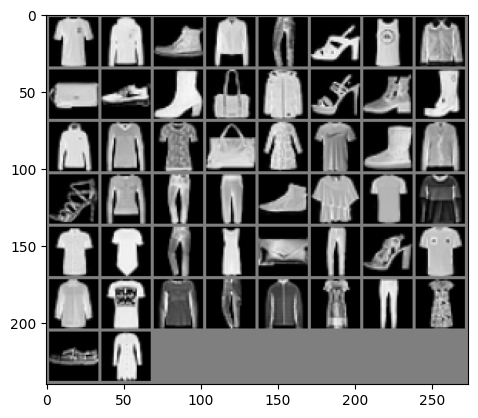

In [7]:
import torchvision


# Display some of the images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize

    npimg = img.cpu().detach().numpy()

    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()


def show_grid(images):
    imshow(torchvision.utils.make_grid(images))

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

show_grid(images)

# Network Architecture
We will implemnet gernerator and descriminator/critic as defined in "Improved Training of Wasserstein GANs" papaer for CIFAR10We decided to resize the FashionMNIST images from 28X28X1 to 32X32X1 to be able to use same conv layers used in the paper



# Generator

### conv dimensions
convolution dimensions are calculated as follows: $ x = \frac{W - k + 2P}{S} + 1 $ deconv dimensions are calculated as follows: $ x = S(W-1) + k - 2P + F $ where: - W is the input image size - k is the kernel size - P is the padding - S is the stride - F is the output padding


In [47]:


class Generator(nn.Module):

    def __init__(self,
                 dim=DIM,
                 latent_dim = LATENT_DIM):

        super(Generator, self).__init__()

        self.dim = dim
        self.latent_dim = latent_dim

        # 1. Fully connected:
        # 128 -> 4*4*4*dim
        self.linear = nn.Linear(latent_dim,
                                4*4*4*dim)

        self.bn1 = nn.BatchNorm1d(4*4*4*dim)

        # 2. deConv
        # (4x4) 4dim -> (8x8) 2dim
        self.deconv2 = nn.ConvTranspose2d(4*dim,
                                          2*dim,
                                          kernel_size=5,
                                          stride=2,
                                          padding=2,
                                          output_padding=1)
        self.bn2 = nn.BatchNorm2d(2*dim)

        # 3. deConv
        # (8x8) 2dim -> (16x16) dim
        self.deconv3 = nn.ConvTranspose2d(2*dim,
                                          dim,
                                          kernel_size=5,
                                          stride=2,
                                          padding=2,
                                          output_padding=1)
        self.bn3 = nn.BatchNorm2d(dim)

        # 4. deConv
        #(16x16) dim -> (32X32) 1
        self.deconv4 = nn.ConvTranspose2d(dim,
                                          in_channels,
                                          kernel_size=5,
                                          stride=2,
                                          padding=2,
                                          output_padding=1)
        self.apply(self._weights_init)

    # avoid vanishing gradients due to bad initialization
    def _weights_init(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, a=0.2, nonlinearity='leaky_relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    # TODO : complete forward function
    #  check if we need to add noise to the forward function
    def forward(self, n_samples, noise=None):
        if noise is None:
            noise = torch.randn(n_samples, self.latent_dim).to(device)

        # 1. Fully connected
        x = self.linear(noise)
        x = self.bn1(x)
        x = F.relu(x)
        x = x.view(-1, 4*self.dim, 4, 4)

        # 2.Deconv
        x = self.deconv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        # 3. Deconv
        x = self.deconv3(x)
        x = self.bn3(x)
        x = F.relu(x)

        # 4. Deconv
        x = self.deconv4(x)
        x = torch.tanh(x)

        return x


 # Discriminator

convolution dimensions are calculated as follows: $ x = \frac{W - k + 2P}{S} + 1 $ deconv dimensions are calculated as follows: $ x = S(W-1) + k - 2P + F $ where: - W is the input image size - k is the kernel size - P is the padding - S is the stride - F is the output padding

In [37]:
class Discriminator(nn.Module):
    def __init__(self,
                dim = DIM,
                in_channels = 1):

        super(Discriminator, self).__init__()
        self.in_features = in_channels
        self.dim=dim
        self.conv1 = nn.Conv2d(kernel_size=5,
                             in_channels=in_channels,
                             out_channels=self.dim,
                             stride=2,) # dimX14X4

        self.conv2 = nn.Conv2d(kernel_size=5,
                                in_channels=self.dim,
                                out_channels=2*self.dim,
                                stride=2,) # 2dimX5X5
        self.batch_norm2 = nn.BatchNorm2d(2*self.dim)

        self.conv3 = nn.Conv2d(kernel_size=1,
                                in_channels=2*self.dim,
                                out_channels=4*self.dim,
                                stride=1,) # 4dimX5X5
        self.batch_norm3 = nn.BatchNorm2d(4*self.dim)

        self.fc = nn.Linear(4*5*5*self.dim, 1)
        self.apply(self._weights_init)

    def _weights_init(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, a=0.2, nonlinearity='leaky_relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)


    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), negative_slope=0.2)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = F.leaky_relu(x, negative_slope=0.2)
        x = self.conv3(x)
        x = self.batch_norm3(x)
        x = F.leaky_relu(x, negative_slope=0.2)
        x = x.view(-1, 4*5*5*self.dim)  # Flatten
        x = self.fc(x)
        x = F.tanh(x)
        return x


In [38]:
class GAN(nn.Module):
    def __init__(self,
                 dim=DIM,
                 mode='wgan',
                 latent_dim=LATENT_DIM,
                 ):
        super(GAN, self).__init__()
        self.generator = Generator(dim = dim,
                                   mode = mode,
                                   latent_dim= latent_dim)
        self.discriminator = Discriminator(dim = dim,
                                           mode = mode,in_channels=in_channels)


# Evaluation
## evaluation metric - Inception score
we define our evaluation metric as the inception score:

In [39]:
## Inception score (Evaluation)
def inception_score(images, batch_size=32, splits=10):
    # Load pre-trained InceptionV3 model
    inception_model = inception_v3(pretrained=True, transform_input=False).eval()
    
    def get_pred(x):
        with torch.no_grad():
            # Upsample images as InceptionV3 requires min 299x299
            x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
            # InceptionV3 needs input shape of N x 3 x 299 x 299
            x = x.repeat(1, 3, 1, 1)
            x = inception_model(x)
        return F.softmax(x, dim=1).cpu().numpy()
    
    # Resize images to 299x299 as required by InceptionV3
    images = [TF.resize(img, (299, 299)) for img in images]
    images = torch.stack(images)
    
    # Calculate predictions
    preds = []
    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size]
        preds.append(get_pred(batch))
    preds = np.concatenate(preds, axis=0)
    
    # Calculate Inception Score
    split_scores = []
    for k in range(splits):
        part = preds[k * (len(preds) // splits): (k + 1) * (len(preds) // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))
    
    return np.mean(split_scores), np.std(split_scores)

def disc_cost (mode,disc_fake,disc_real):
    return (torch.mean(disc_fake) - torch.mean(disc_real) if mode == 'wgan' else
                            (F.binary_cross_entropy_with_logits(disc_fake, torch.zeros_like(disc_fake)) +
                                F.binary_cross_entropy_with_logits(disc_real, torch.ones_like(disc_real))) / 2.)

def gen_cost(disc_fake,mode):
    return (-torch.mean(disc_fake) if mode == 'wgan' else F.binary_cross_entropy_with_logits(disc_fake, torch.ones_like(disc_fake)))

## Test the generator
can be removed before submission

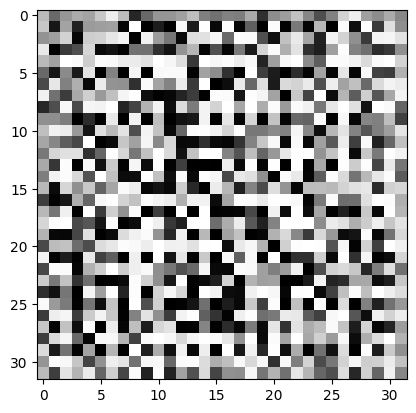

In [40]:
generator = Generator().to(device)
img = generator.forward(10)
imshow(img[0])

## Test the discriminator

In [41]:
discriminator = Discriminator().to(device)
output = discriminator.forward(img)
print(output)


tensor([[ 0.0941],
        [ 0.4382],
        [ 0.0057],
        [ 0.7407],
        [ 0.0464],
        [-0.2238],
        [ 0.9054],
        [ 0.8395],
        [-0.0460],
        [ 0.9012]], grad_fn=<TanhBackward0>)


#Lost Function/ Inception

In [42]:
def clip_weights(net, clip_value):
    for p in net.parameters():
        p.data.clamp_(-clip_value, clip_value)

In [43]:
# TODO: 1. add CUDA support and check in colab
#       2. add model saver - to .pt file
#       3. add imshow function on top of the notebook, ONLY call it
#       4. enable a continue training option, save the last epoch number and continue from there

# class GAN:
#     def __init__(self, generator, discriminator, mode, train_loader, val_loader, gen_iters, critic_iters, batch_size = BATCH_SIZE):
#         self.generator = generator
#         self.discriminator = discriminator
#         self.mode = mode
#         self.gen_optimizer = optim.RMSprop(self.generator.parameters(), lr=5e-5)
#         self.disc_optimizer = optim.RMSprop(self.discriminator.parameters(), lr=5e-5)
#         self.train_loader = train_loader
#         self.val_loader = val_loader
#         self.gen_iters =gen_iters
#         self.critic_iters = critic_iters
#         self.batch_size = batch_size
#
#     # NADAV/REUT: Do we need to defrenciate the optimizers?
#  #   self.setup_optimizers()
#
#     #def setup_optimizers(self):
#     #     if self.mode == 'wgan':
#     #         self.gen_optimizer = optim.RMSprop(self.generator.parameters(), lr=5e-5)
#     #         self.disc_optimizer = optim.RMSprop(self.discriminator.parameters(), lr=5e-5)
#     #     elif self.mode == 'dcgan':
#     #         self.gen_optimizer = optim.Adam(self.generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
#     #         self.disc_optimizer = optim.Adam(self.discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))
#
#   #TODO: Consider change it if training is too heavey
#     def inf_train_gen(self):
#         while True:
#             for images, _ in self.train_loader:
#                 yield images
#
#
#     def train(self):
#         # Define a clipping value (e.g., 0.01)
#         clipping_value = 1
#
#         # wandb
#         wandb.init(
#             # set the wandb project where this run will be logged
#             project="GANs",
#             # track hyperparameters and run metadata
#             config={
#                 f"learning_rate": 5e-5,
#                 f"architecture": "VAE",
#                 f"dataset": "Fashion MNIST",
#                 })
#         # Watch the model to log gradients and parameters
#         wandb.watch(self.generator, log="all", log_freq=100)
#         wandb.watch(self.discriminator, log="all", log_freq=100)
#
#         for iteration in range(self.gen_iters):
#             start_time = time.time()
#             # Train generator
#             self.generator.train()
#             self.gen_optimizer.zero_grad()
#             fake_data = self.generator(self.batch_size)
#             disc_fake = self.discriminator(fake_data)
#             gen_cost_val = gen_cost(mode=self.mode,disc_fake=disc_fake )
#             gen_cost_val.backward()
#             self.gen_optimizer.step()
#
#             # Train critic/dicriminator
#             disc_iters = 1 if self.mode == 'dcgan' else self.critic_iters
#             for _ in range(disc_iters):
#                 _data = next(self.inf_train_gen()).to(device)
#                 self.discriminator.train()
#                 self.disc_optimizer.zero_grad()
#
#
#                 disc_real = self.discriminator(_data)
#
#                 # forward pass
#                 fake_data = self.generator(self.batch_size)
#                 disc_fake = self.discriminator(fake_data)
#
#                 #loss
#                 disc_cost_val =disc_cost(mode=self.mode,disc_real=disc_real,disc_fake=disc_fake)
#                 #backprop
#                 disc_cost_val.backward()
#                 # grad clipping
#                 torch.nn.utils.clip_grad_norm_(self.discriminator.parameters(), max_norm=1.0)
#                 self.disc_optimizer.step()
#
#                 # Apply weight clipping for WGAN
#                 if self.mode == 'wgan':
#                     clip_weights(self.discriminator, clipping_value)
#
#             print(f"Iteration {iteration}, Generator Cost: {gen_cost_val}, Discriminator Cost: {disc_cost_val} Time: {time.time() - start_time}")
#             wandb.log({"Generator Cost": gen_cost_val, "Discriminator Cost": disc_cost_val}, step=iteration)
#
#             # Logging
#
#             # Calculate inception score every 1K iters
#             if iteration % 1000 == 999:
#                 with torch.no_grad():
#                     # z = torch.randn(1000, 100, 1, 1).to(device) this will break the code because it doesn't match the generator latent dimension
#                     generated_imgs = self.generator(1000)
#                     generated_imgs = self.generated_imgs.cpu()
#                     inception_mean, inception_std = inception_score(generated_imgs)
#                     print(f"Genrator Iteration {iteration}: Inception Score: {inception_mean} ± {inception_std}")
#                     wandb.log({"Inception Score": inception_mean}, step=iteration)
#
#
#                     imshow(generated_imgs[0])
#                     plt.show()
#
#             # Calculate val loss of the discriminator and generate samples every 100 iters
#             if iteration % 100 == 99:
#
#                 val_disc_costs = []
#                 for images, _ in self.val_loader:
#                     # images = torch.tensor(images).float()  # Convert images to a PyTorch tensor
#                     fake_data = self.generator(self.batch_size)
#                     disc_fake = self.discriminator(fake_data)
#                     _dev_disc_cost = disc_cost(mode=self.mode,disc_real=images,disc_fake=disc_fake)  # Compute the discriminator cost
#                     val_disc_costs.append(_dev_disc_cost.item())  # Append the cost to the list
#                     wandb.log({"Validation Discriminator Cost": _dev_disc_cost}, step=iteration)
#
#                 imshow(fake_data[0])
#                 plt.show()
#
#
#
#             # mean_dev_disc_cost = np.mean(val_disc_costs) #TODO plot
#
#
#







In [44]:
# dc_gen=Generator(dim = DIM,latent_dim= LATENT_DIM)
# dc_disc = Discriminator(dim = DIM,in_channels=in_channels)
# dcgan = GAN(mode = 'wgan'
#             , train_loader=train_loader
#             , gen_iters = GEN_ITERS
#             , critic_iters=CRITIC_ITERS
#             ,batch_size = BATCH_SIZE
#             ,discriminator = dc_disc
#             ,generator = dc_gen
#             ,val_loader=test_loader)
# dcgan.train()

# Training loop

In [45]:
  #TODO: Consider change it if training is too heavey
def inf_train_gen(train_loader = train_loader):
    while True:
        for images, _ in train_loader:
            yield images


def train(generator = generator,
          discriminator = discriminator,
          batch_size=BATCH_SIZE,
          train_loader=train_loader,
          val_loader=test_loader,

          lr = 5e-5,
          gen_iters=GEN_ITERS,
          critic_iters=CRITIC_ITERS,
          clipping_value=0.01,
          mode='wgan'

          ):

    gen_optimizer = optim.RMSprop(generator.parameters(), lr=lr)
    disc_optimizer = optim.RMSprop(discriminator.parameters(), lr=lr)


    # wandb
    wandb.init(
        # set the wandb project where this run will be logged
        project="GANs",
        # track hyperparameters and run metadata
        config={
            f"learning_rate": 5e-5,
            f"architecture": "VAE",
            f"dataset": "Fashion MNIST",
        })
    # Watch the model to log gradients and parameters
    wandb.watch(generator, log="all", log_freq=100)
    wandb.watch(discriminator, log="all", log_freq=100)

    for iteration in range(gen_iters):
        start_time = time.time()
        # Train generator
        generator.train()
        gen_optimizer.zero_grad()
        fake_data = generator(batch_size)
        disc_fake = discriminator(fake_data)
        gen_cost_val = gen_cost(mode=mode,disc_fake=disc_fake )
        gen_cost_val.backward()
        gen_optimizer.step()

        # Train critic/dicriminator
        disc_iters = 1 if mode == 'dcgan' else critic_iters
        for _ in range(disc_iters):
            _data = next(inf_train_gen()).to(device)
            discriminator.train()
            disc_optimizer.zero_grad()


            disc_real = discriminator(_data)

            # forward pass
            fake_data = generator(batch_size)
            disc_fake = discriminator(fake_data)

            #loss
            disc_cost_val =disc_cost(mode=mode,disc_real=disc_real,disc_fake=disc_fake)
            #backprop
            disc_cost_val.backward()
            # grad clipping
            torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=0.1)
            disc_optimizer.step()

            # Apply weight clipping for WGAN
            if mode == 'wgan':
                clip_weights(discriminator, clipping_value)

        print(f"Iteration {iteration}, Generator Cost: {gen_cost_val}, Discriminator Cost: {disc_cost_val} Time: {time.time() - start_time}")
        wandb.log({"Generator Cost": gen_cost_val, "Discriminator Cost": disc_cost_val}, step=iteration)

        # Logging

        # Calculate inception score every 1K iters
        if iteration % 1000 == 999:
            with torch.no_grad():
                # z = torch.randn(1000, 100, 1, 1).to(device) this will break the code because it doesn't match the generator latent dimension
                generated_imgs = generator(100)
                generated_imgs = generated_imgs.cpu()
                inception_mean, inception_std = inception_score(generated_imgs)
                print(f"Genrator Iteration {iteration}: Inception Score: {inception_mean} ± {inception_std}")
                wandb.log({"Inception Score": inception_mean}, step=iteration)


                imshow(generated_imgs[0])
                plt.show()

        # Calculate val loss of the discriminator and generate samples every 100 iters
        if iteration % 100 == 99:

            val_disc_costs = []
            for images, _ in val_loader:
                # images = torch.tensor(images).float()  # Convert images to a PyTorch tensor
                fake_data = generator(batch_size)
                disc_fake = discriminator(fake_data)
                _dev_disc_cost = disc_cost(mode=mode,disc_real=images,disc_fake=disc_fake)  # Compute the discriminator cost
                val_disc_costs.append(_dev_disc_cost.item())  # Append the cost to the list
                wandb.log({"Validation Discriminator Cost": _dev_disc_cost}, step=iteration)

            imshow(fake_data[0])
            plt.show()



        # mean_dev_disc_cost = np.mean(val_disc_costs) #TODO plot


# Training a WGAN

Discriminator Cost,▇▅▇▄▄▂▂▂▃▃▃▁█▂▄▆▆▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
Generator Cost,▄▆▃▅▅██▅▇▂▆█▂▇▅▁▂▂▂▂▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
Inception Score,▁
Validation Discriminator Cost,█▂▁▅▅▅▅▅▅▅
Discriminator Cost,-0.407
Generator Cost,0.06051
Inception Score,1.00346
Validation Discriminator Cost,0.35663


Iteration 0, Generator Cost: -0.2039729356765747, Discriminator Cost: -0.020385373383760452 Time: 0.7174513339996338
Iteration 1, Generator Cost: 0.01416489016264677, Discriminator Cost: -0.044314295053482056 Time: 0.7985813617706299
Iteration 2, Generator Cost: 0.029571490362286568, Discriminator Cost: -0.06457118690013885 Time: 0.8002495765686035
Iteration 3, Generator Cost: 0.0434076227247715, Discriminator Cost: -0.08214530348777771 Time: 0.7820382118225098
Iteration 4, Generator Cost: 0.055181365460157394, Discriminator Cost: -0.09810205549001694 Time: 0.953815221786499
Iteration 5, Generator Cost: 0.06658168882131577, Discriminator Cost: -0.11160844564437866 Time: 0.9222195148468018
Iteration 6, Generator Cost: 0.07684148102998734, Discriminator Cost: -0.13187071681022644 Time: 0.8081083297729492
Iteration 7, Generator Cost: 0.086741141974926, Discriminator Cost: -0.14217230677604675 Time: 0.8598990440368652
Iteration 8, Generator Cost: 0.09554661065340042, Discriminator Cost: -0

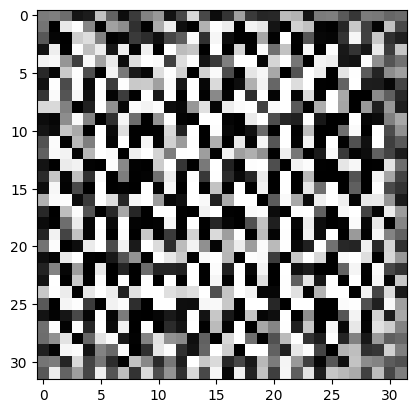

Iteration 100, Generator Cost: 0.14808566868305206, Discriminator Cost: -0.2977698743343353 Time: 0.6888411045074463
Iteration 101, Generator Cost: 0.1328248381614685, Discriminator Cost: -0.3423563241958618 Time: 0.9227468967437744
Iteration 102, Generator Cost: 0.19305367767810822, Discriminator Cost: -0.4307561218738556 Time: 1.0315563678741455
Iteration 103, Generator Cost: 0.24633477628231049, Discriminator Cost: -0.44719088077545166 Time: 1.6623528003692627
Iteration 104, Generator Cost: 0.2605619728565216, Discriminator Cost: -0.4141751229763031 Time: 0.8244788646697998
Iteration 105, Generator Cost: 0.23224087059497833, Discriminator Cost: -0.27911752462387085 Time: 0.7509746551513672
Iteration 106, Generator Cost: 0.11439850181341171, Discriminator Cost: -0.22313830256462097 Time: 0.6624081134796143
Iteration 107, Generator Cost: 0.07944026589393616, Discriminator Cost: -0.015357360243797302 Time: 0.6687684059143066
Iteration 108, Generator Cost: -0.148223415017128, Discrimina

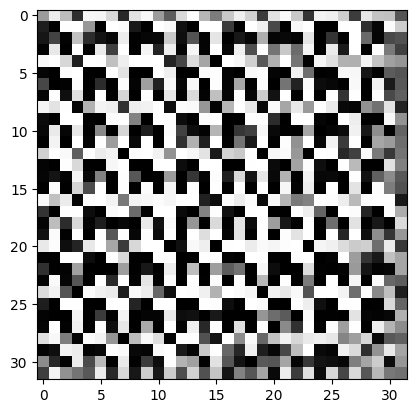

Iteration 200, Generator Cost: 0.17387737333774567, Discriminator Cost: -0.29590198397636414 Time: 1.9831161499023438
Iteration 201, Generator Cost: 0.10324787348508835, Discriminator Cost: -0.22393472492694855 Time: 1.662508249282837
Iteration 202, Generator Cost: 0.056449878960847855, Discriminator Cost: -0.20693524181842804 Time: 2.0572550296783447
Iteration 203, Generator Cost: 0.01880538836121559, Discriminator Cost: -0.28046953678131104 Time: 1.6681187152862549
Iteration 204, Generator Cost: 0.08550626784563065, Discriminator Cost: -0.2041618973016739 Time: 1.6461906433105469
Iteration 205, Generator Cost: 0.041866324841976166, Discriminator Cost: -0.3025010824203491 Time: 1.736893653869629
Iteration 206, Generator Cost: 0.11972557753324509, Discriminator Cost: -0.4226095676422119 Time: 1.922607183456421
Iteration 207, Generator Cost: 0.20978759229183197, Discriminator Cost: -0.4227369427680969 Time: 2.1711645126342773
Iteration 208, Generator Cost: 0.22242240607738495, Discrimin

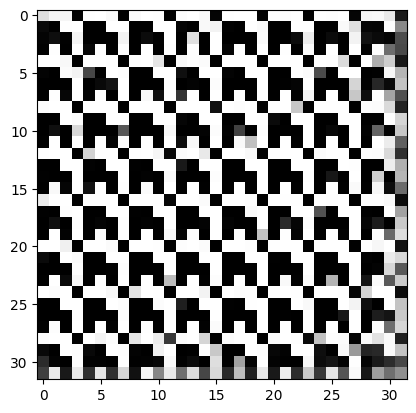

Iteration 300, Generator Cost: 0.053031183779239655, Discriminator Cost: -0.3492806553840637 Time: 1.9051868915557861
Iteration 301, Generator Cost: 0.05937541648745537, Discriminator Cost: -0.33461982011795044 Time: 1.625910997390747
Iteration 302, Generator Cost: 0.05442242696881294, Discriminator Cost: -0.34611088037490845 Time: 1.5246660709381104
Iteration 303, Generator Cost: 0.05013361945748329, Discriminator Cost: -0.33186185359954834 Time: 1.7393970489501953
Iteration 304, Generator Cost: 0.05049274489283562, Discriminator Cost: -0.3338228166103363 Time: 1.8593735694885254
Iteration 305, Generator Cost: 0.044337235391139984, Discriminator Cost: -0.33451738953590393 Time: 1.863349437713623
Iteration 306, Generator Cost: 0.051165465265512466, Discriminator Cost: -0.337408185005188 Time: 1.815068244934082
Iteration 307, Generator Cost: 0.05427020415663719, Discriminator Cost: -0.338783860206604 Time: 1.8042407035827637
Iteration 308, Generator Cost: 0.0539407841861248, Discriminat

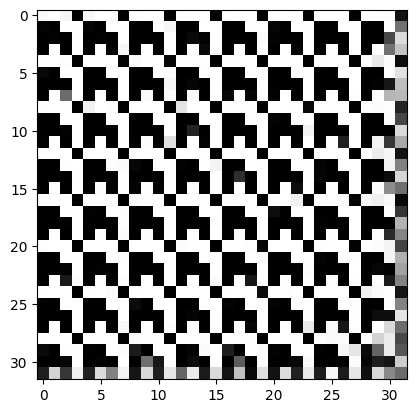

Iteration 400, Generator Cost: 0.051812756806612015, Discriminator Cost: -0.35621562600135803 Time: 2.2094874382019043
Iteration 401, Generator Cost: 0.052175525575876236, Discriminator Cost: -0.4040876030921936 Time: 2.1253132820129395
Iteration 402, Generator Cost: 0.05283941701054573, Discriminator Cost: -0.38758713006973267 Time: 2.431828498840332
Iteration 403, Generator Cost: 0.050731219351291656, Discriminator Cost: -0.3989018499851227 Time: 2.056197166442871
Iteration 404, Generator Cost: 0.05552269518375397, Discriminator Cost: -0.39909523725509644 Time: 2.2594192028045654
Iteration 405, Generator Cost: 0.05661753565073013, Discriminator Cost: -0.39217498898506165 Time: 1.9174671173095703
Iteration 406, Generator Cost: 0.05767570063471794, Discriminator Cost: -0.38785749673843384 Time: 1.783022165298462
Iteration 407, Generator Cost: 0.056837547570466995, Discriminator Cost: -0.40113914012908936 Time: 1.907942771911621
Iteration 408, Generator Cost: 0.05495096743106842, Discri

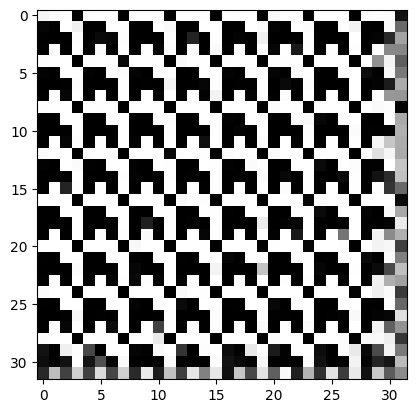

Iteration 500, Generator Cost: 0.08865595608949661, Discriminator Cost: -0.4204252064228058 Time: 2.2846553325653076
Iteration 501, Generator Cost: 0.08772089332342148, Discriminator Cost: -0.40815141797065735 Time: 2.2474005222320557
Iteration 502, Generator Cost: 0.08970728516578674, Discriminator Cost: -0.39084592461586 Time: 2.0386228561401367
Iteration 503, Generator Cost: 0.08842483162879944, Discriminator Cost: -0.4255635440349579 Time: 1.8721923828125
Iteration 504, Generator Cost: 0.08917561173439026, Discriminator Cost: -0.4090368151664734 Time: 1.7463085651397705
Iteration 505, Generator Cost: 0.09089686721563339, Discriminator Cost: -0.43264761567115784 Time: 2.0937438011169434
Iteration 506, Generator Cost: 0.08865074813365936, Discriminator Cost: -0.40740543603897095 Time: 2.2258543968200684
Iteration 507, Generator Cost: 0.09125154465436935, Discriminator Cost: -0.40780290961265564 Time: 2.1663639545440674
Iteration 508, Generator Cost: 0.09073273837566376, Discriminator

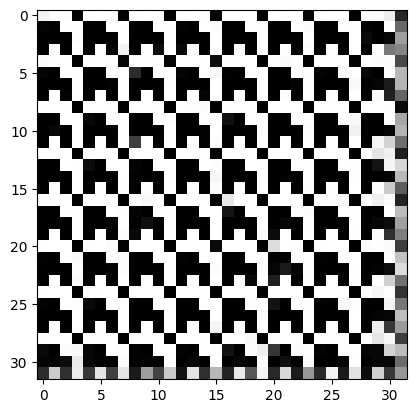

Iteration 600, Generator Cost: 0.10015115141868591, Discriminator Cost: -0.4030473828315735 Time: 2.4272255897521973
Iteration 601, Generator Cost: 0.09934421628713608, Discriminator Cost: -0.41336768865585327 Time: 2.6131672859191895
Iteration 602, Generator Cost: 0.09831933677196503, Discriminator Cost: -0.4173015356063843 Time: 2.1002793312072754
Iteration 603, Generator Cost: 0.09945542365312576, Discriminator Cost: -0.4103938341140747 Time: 2.3870739936828613
Iteration 604, Generator Cost: 0.10037918388843536, Discriminator Cost: -0.4128987193107605 Time: 2.586472749710083
Iteration 605, Generator Cost: 0.09937145560979843, Discriminator Cost: -0.43066245317459106 Time: 2.479046583175659
Iteration 606, Generator Cost: 0.10040278732776642, Discriminator Cost: -0.41037148237228394 Time: 2.2362496852874756
Iteration 607, Generator Cost: 0.10108180344104767, Discriminator Cost: -0.41877901554107666 Time: 2.9542386531829834
Iteration 608, Generator Cost: 0.10049644112586975, Discrimina

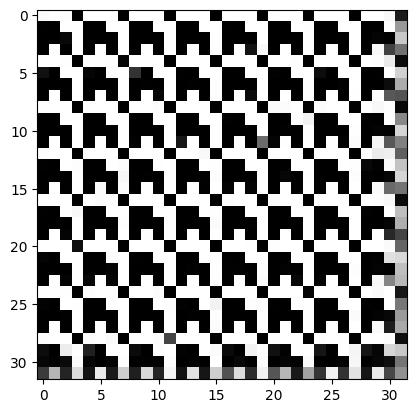

Iteration 700, Generator Cost: 0.10717958211898804, Discriminator Cost: -0.3980370759963989 Time: 2.6554582118988037
Iteration 701, Generator Cost: 0.10652897506952286, Discriminator Cost: -0.4267413914203644 Time: 2.544628620147705
Iteration 702, Generator Cost: 0.10677294433116913, Discriminator Cost: -0.4249362349510193 Time: 2.6446406841278076
Iteration 703, Generator Cost: 0.10718671977519989, Discriminator Cost: -0.4205828905105591 Time: 2.5027034282684326
Iteration 704, Generator Cost: 0.10756349563598633, Discriminator Cost: -0.42585691809654236 Time: 2.1895768642425537
Iteration 705, Generator Cost: 0.1067085713148117, Discriminator Cost: -0.4159736931324005 Time: 2.1173062324523926
Iteration 706, Generator Cost: 0.1066305935382843, Discriminator Cost: -0.4109736680984497 Time: 2.7419955730438232
Iteration 707, Generator Cost: 0.10697227716445923, Discriminator Cost: -0.4125799238681793 Time: 2.3599460124969482
Iteration 708, Generator Cost: 0.10692079365253448, Discriminator 

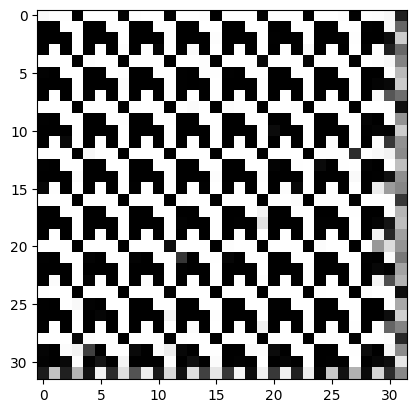

Iteration 800, Generator Cost: 0.10738144814968109, Discriminator Cost: -0.41817694902420044 Time: 1.5484251976013184
Iteration 801, Generator Cost: 0.10627787560224533, Discriminator Cost: -0.4213435649871826 Time: 1.537184238433838
Iteration 802, Generator Cost: 0.10669010132551193, Discriminator Cost: -0.41588109731674194 Time: 1.389482021331787
Iteration 803, Generator Cost: 0.10823884606361389, Discriminator Cost: -0.42374157905578613 Time: 1.3378708362579346
Iteration 804, Generator Cost: 0.10720875859260559, Discriminator Cost: -0.42412424087524414 Time: 1.2159647941589355
Iteration 805, Generator Cost: 0.10677453130483627, Discriminator Cost: -0.42011988162994385 Time: 1.137091875076294
Iteration 806, Generator Cost: 0.10733693838119507, Discriminator Cost: -0.4214845895767212 Time: 1.1813814640045166
Iteration 807, Generator Cost: 0.10727466642856598, Discriminator Cost: -0.42959722876548767 Time: 1.1335079669952393
Iteration 808, Generator Cost: 0.10748498886823654, Discrimin

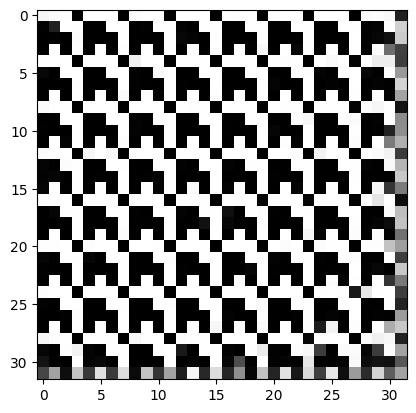

Iteration 900, Generator Cost: 0.11031483858823776, Discriminator Cost: -0.4305857717990875 Time: 3.1244544982910156
Iteration 901, Generator Cost: 0.11014976352453232, Discriminator Cost: -0.43013232946395874 Time: 2.481424331665039
Iteration 902, Generator Cost: 0.11049231886863708, Discriminator Cost: -0.41260483860969543 Time: 2.8912906646728516
Iteration 903, Generator Cost: 0.10858967155218124, Discriminator Cost: -0.4246566891670227 Time: 2.623941421508789
Iteration 904, Generator Cost: 0.10855694860219955, Discriminator Cost: -0.425670325756073 Time: 2.7885682582855225
Iteration 905, Generator Cost: 0.10866806656122208, Discriminator Cost: -0.42102134227752686 Time: 2.976555347442627
Iteration 906, Generator Cost: 0.10963596403598785, Discriminator Cost: -0.424766480922699 Time: 2.7483034133911133
Iteration 907, Generator Cost: 0.11072595417499542, Discriminator Cost: -0.43541213870048523 Time: 2.3970210552215576
Iteration 908, Generator Cost: 0.10761349648237228, Discriminator

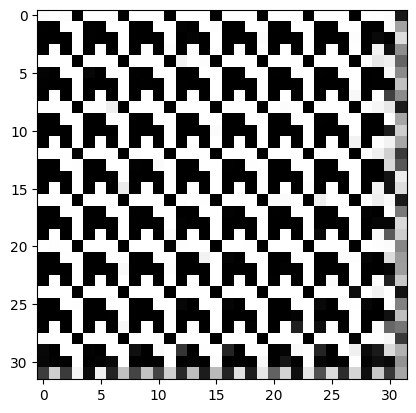

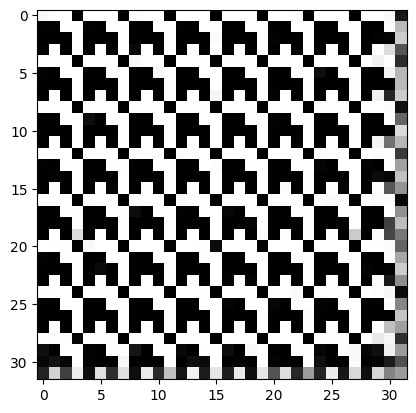

Iteration 1000, Generator Cost: 0.11017656326293945, Discriminator Cost: -0.41183894872665405 Time: 2.9898908138275146
Iteration 1001, Generator Cost: 0.10991004854440689, Discriminator Cost: -0.4366840720176697 Time: 3.1101760864257812
Iteration 1002, Generator Cost: 0.10987149924039841, Discriminator Cost: -0.4214230179786682 Time: 2.7322657108306885
Iteration 1003, Generator Cost: 0.10949825495481491, Discriminator Cost: -0.4247240126132965 Time: 2.8215770721435547
Iteration 1004, Generator Cost: 0.10890720039606094, Discriminator Cost: -0.41713330149650574 Time: 2.7469286918640137
Iteration 1005, Generator Cost: 0.10973671078681946, Discriminator Cost: -0.4253927767276764 Time: 2.714547872543335
Iteration 1006, Generator Cost: 0.10969176888465881, Discriminator Cost: -0.43827682733535767 Time: 2.894622802734375
Iteration 1007, Generator Cost: 0.10936398804187775, Discriminator Cost: -0.42896366119384766 Time: 2.7956643104553223
Iteration 1008, Generator Cost: 0.10945437103509903, D

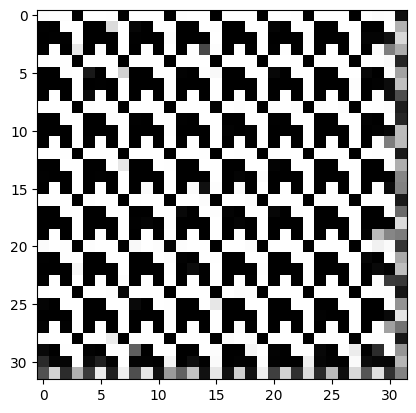

Iteration 1100, Generator Cost: 0.10933727025985718, Discriminator Cost: -0.4307447373867035 Time: 2.7008912563323975
Iteration 1101, Generator Cost: 0.1105092242360115, Discriminator Cost: -0.416373610496521 Time: 2.508312225341797
Iteration 1102, Generator Cost: 0.11111334711313248, Discriminator Cost: -0.44540688395500183 Time: 2.552389621734619
Iteration 1103, Generator Cost: 0.11021938920021057, Discriminator Cost: -0.4183937907218933 Time: 2.5976004600524902
Iteration 1104, Generator Cost: 0.11047335714101791, Discriminator Cost: -0.4461515247821808 Time: 2.766299247741699
Iteration 1105, Generator Cost: 0.10918793827295303, Discriminator Cost: -0.4299246072769165 Time: 2.640944242477417
Iteration 1106, Generator Cost: 0.10961488634347916, Discriminator Cost: -0.4404923915863037 Time: 2.2227699756622314
Iteration 1107, Generator Cost: 0.1103862076997757, Discriminator Cost: -0.41419070959091187 Time: 1.6486444473266602
Iteration 1108, Generator Cost: 0.10990560799837112, Discrimi

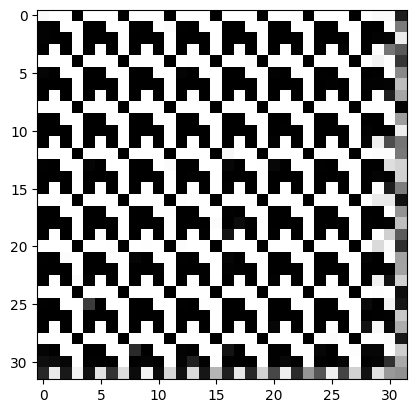

Iteration 1200, Generator Cost: 0.10946039855480194, Discriminator Cost: -0.42540866136550903 Time: 2.541095733642578
Iteration 1201, Generator Cost: 0.1101219430565834, Discriminator Cost: -0.4320450723171234 Time: 2.846583604812622
Iteration 1202, Generator Cost: 0.10995674133300781, Discriminator Cost: -0.43081972002983093 Time: 2.486780881881714
Iteration 1203, Generator Cost: 0.10952568799257278, Discriminator Cost: -0.4261751174926758 Time: 2.905393600463867
Iteration 1204, Generator Cost: 0.1096826046705246, Discriminator Cost: -0.4228145182132721 Time: 3.197762966156006
Iteration 1205, Generator Cost: 0.10952845215797424, Discriminator Cost: -0.41863900423049927 Time: 2.638598680496216
Iteration 1206, Generator Cost: 0.11027472466230392, Discriminator Cost: -0.4523731470108032 Time: 2.766201972961426
Iteration 1207, Generator Cost: 0.11038865894079208, Discriminator Cost: -0.436774343252182 Time: 2.5089962482452393
Iteration 1208, Generator Cost: 0.10989822447299957, Discrimina

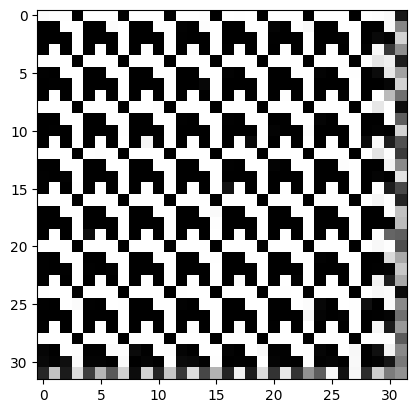

Iteration 1300, Generator Cost: 0.10921599715948105, Discriminator Cost: -0.45503172278404236 Time: 2.4395806789398193
Iteration 1301, Generator Cost: 0.10938835144042969, Discriminator Cost: -0.4179077446460724 Time: 1.6615371704101562
Iteration 1302, Generator Cost: 0.1096012145280838, Discriminator Cost: -0.44011902809143066 Time: 1.8895745277404785
Iteration 1303, Generator Cost: 0.11386816203594208, Discriminator Cost: -0.41534262895584106 Time: 2.599486827850342
Iteration 1304, Generator Cost: 0.11038655042648315, Discriminator Cost: -0.4126843214035034 Time: 2.8966031074523926
Iteration 1305, Generator Cost: 0.11038044095039368, Discriminator Cost: -0.4352262020111084 Time: 2.7004554271698
Iteration 1306, Generator Cost: 0.1098054051399231, Discriminator Cost: -0.42038750648498535 Time: 2.5275087356567383
Iteration 1307, Generator Cost: 0.10995472222566605, Discriminator Cost: -0.42560386657714844 Time: 2.6265530586242676
Iteration 1308, Generator Cost: 0.10962196439504623, Disc

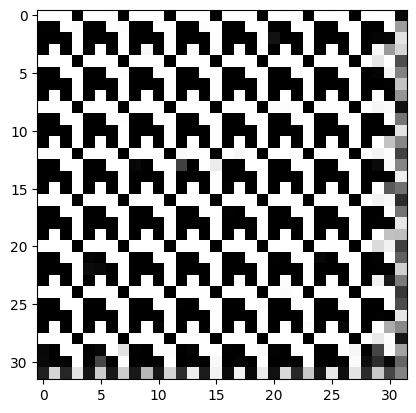

Iteration 1400, Generator Cost: 0.1092158779501915, Discriminator Cost: -0.4333583116531372 Time: 3.0899667739868164
Iteration 1401, Generator Cost: 0.10974373668432236, Discriminator Cost: -0.43248820304870605 Time: 3.0379629135131836
Iteration 1402, Generator Cost: 0.11041343957185745, Discriminator Cost: -0.43324601650238037 Time: 2.946814775466919
Iteration 1403, Generator Cost: 0.10865623503923416, Discriminator Cost: -0.43962427973747253 Time: 2.8590118885040283
Iteration 1404, Generator Cost: 0.10938198119401932, Discriminator Cost: -0.4391242265701294 Time: 2.577849864959717
Iteration 1405, Generator Cost: 0.10956107825040817, Discriminator Cost: -0.4302029609680176 Time: 1.8711721897125244
Iteration 1406, Generator Cost: 0.10988545417785645, Discriminator Cost: -0.4150216281414032 Time: 2.6550519466400146
Iteration 1407, Generator Cost: 0.11044035106897354, Discriminator Cost: -0.4347531199455261 Time: 1.908717155456543
Iteration 1408, Generator Cost: 0.10986518114805222, Disc

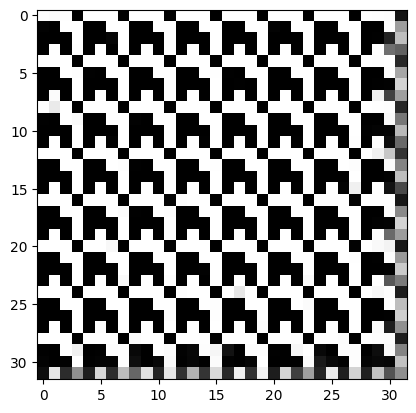

Iteration 1500, Generator Cost: 0.10985613614320755, Discriminator Cost: -0.4491080641746521 Time: 2.950599431991577
Iteration 1501, Generator Cost: 0.10971107333898544, Discriminator Cost: -0.4399757981300354 Time: 2.2093138694763184
Iteration 1502, Generator Cost: 0.10975977033376694, Discriminator Cost: -0.42848435044288635 Time: 2.9638419151306152
Iteration 1503, Generator Cost: 0.10972093790769577, Discriminator Cost: -0.4236406683921814 Time: 2.678647518157959
Iteration 1504, Generator Cost: 0.10985858738422394, Discriminator Cost: -0.4236682951450348 Time: 2.9219467639923096
Iteration 1505, Generator Cost: 0.11021897941827774, Discriminator Cost: -0.42847976088523865 Time: 2.291255474090576
Iteration 1506, Generator Cost: 0.10965484380722046, Discriminator Cost: -0.4435691833496094 Time: 1.3793628215789795
Iteration 1507, Generator Cost: 0.10965684801340103, Discriminator Cost: -0.43267253041267395 Time: 2.3024587631225586
Iteration 1508, Generator Cost: 0.10966770350933075, Dis

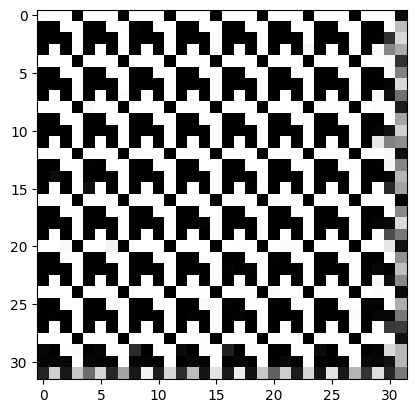

Iteration 1600, Generator Cost: 0.11050967127084732, Discriminator Cost: -0.43994614481925964 Time: 2.666703939437866
Iteration 1601, Generator Cost: 0.11011749505996704, Discriminator Cost: -0.4280177056789398 Time: 2.7517049312591553
Iteration 1602, Generator Cost: 0.11037833988666534, Discriminator Cost: -0.4217258393764496 Time: 2.3889291286468506
Iteration 1603, Generator Cost: 0.11041079461574554, Discriminator Cost: -0.4169100224971771 Time: 1.6372509002685547
Iteration 1604, Generator Cost: 0.11011780053377151, Discriminator Cost: -0.4204806685447693 Time: 2.726583242416382
Iteration 1605, Generator Cost: 0.11026228219270706, Discriminator Cost: -0.43722161650657654 Time: 2.5054049491882324
Iteration 1606, Generator Cost: 0.11036647111177444, Discriminator Cost: -0.43390166759490967 Time: 2.8977606296539307
Iteration 1607, Generator Cost: 0.11030719429254532, Discriminator Cost: -0.4268503785133362 Time: 2.5813539028167725
Iteration 1608, Generator Cost: 0.11023205518722534, Di

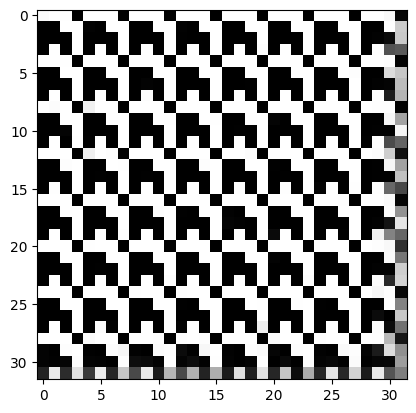

Iteration 1700, Generator Cost: 0.10964350402355194, Discriminator Cost: -0.44536060094833374 Time: 1.6263189315795898
Iteration 1701, Generator Cost: 0.11031217873096466, Discriminator Cost: -0.42816734313964844 Time: 2.542599678039551
Iteration 1702, Generator Cost: 0.11009424924850464, Discriminator Cost: -0.42106860876083374 Time: 2.518040180206299
Iteration 1703, Generator Cost: 0.10985657572746277, Discriminator Cost: -0.41447895765304565 Time: 2.7675089836120605
Iteration 1704, Generator Cost: 0.10984847694635391, Discriminator Cost: -0.443630188703537 Time: 2.0266692638397217
Iteration 1705, Generator Cost: 0.10976649075746536, Discriminator Cost: -0.4446091055870056 Time: 2.6882944107055664
Iteration 1706, Generator Cost: 0.10928487777709961, Discriminator Cost: -0.44225114583969116 Time: 2.4580347537994385
Iteration 1707, Generator Cost: 0.10977798700332642, Discriminator Cost: -0.4212815761566162 Time: 2.560880184173584
Iteration 1708, Generator Cost: 0.10976836830377579, Di

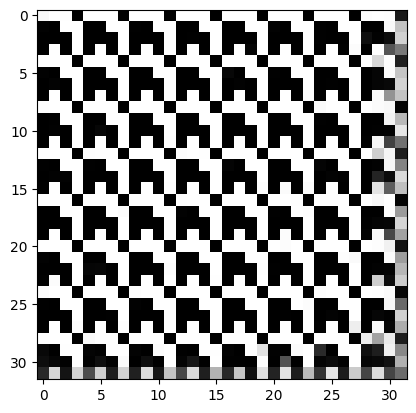

Iteration 1800, Generator Cost: 0.11018843948841095, Discriminator Cost: -0.4418582320213318 Time: 3.1953749656677246
Iteration 1801, Generator Cost: 0.11006899923086166, Discriminator Cost: -0.4494418501853943 Time: 2.8361899852752686
Iteration 1802, Generator Cost: 0.11463982611894608, Discriminator Cost: -0.4293685257434845 Time: 2.265249013900757
Iteration 1803, Generator Cost: 0.10926127433776855, Discriminator Cost: -0.42782872915267944 Time: 2.1509833335876465
Iteration 1804, Generator Cost: 0.1108463928103447, Discriminator Cost: -0.43013644218444824 Time: 2.7448840141296387
Iteration 1805, Generator Cost: 0.11213310062885284, Discriminator Cost: -0.4417875409126282 Time: 3.040600061416626
Iteration 1806, Generator Cost: 0.11029775440692902, Discriminator Cost: -0.4503262937068939 Time: 2.6889894008636475
Iteration 1807, Generator Cost: 0.10927482694387436, Discriminator Cost: -0.44210654497146606 Time: 1.6636230945587158
Iteration 1808, Generator Cost: 0.1098972037434578, Disc

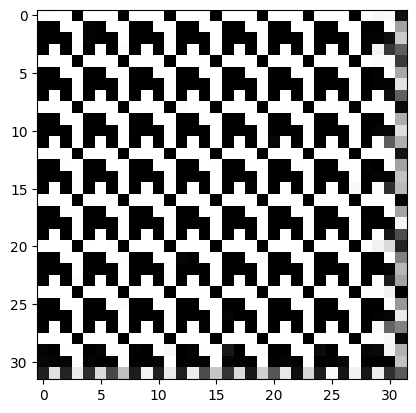

Iteration 1900, Generator Cost: 0.10978163778781891, Discriminator Cost: -0.44132035970687866 Time: 1.5050392150878906
Iteration 1901, Generator Cost: 0.10972657799720764, Discriminator Cost: -0.4388188123703003 Time: 1.3311078548431396
Iteration 1902, Generator Cost: 0.10970677435398102, Discriminator Cost: -0.441336989402771 Time: 1.4944820404052734
Iteration 1903, Generator Cost: 0.10994948446750641, Discriminator Cost: -0.42035818099975586 Time: 1.3403983116149902
Iteration 1904, Generator Cost: 0.10944157838821411, Discriminator Cost: -0.42804384231567383 Time: 1.5421867370605469
Iteration 1905, Generator Cost: 0.10958617925643921, Discriminator Cost: -0.44212740659713745 Time: 1.6061160564422607
Iteration 1906, Generator Cost: 0.1099531427025795, Discriminator Cost: -0.4394274353981018 Time: 1.2781689167022705
Iteration 1907, Generator Cost: 0.10981832444667816, Discriminator Cost: -0.4513799548149109 Time: 1.5966885089874268
Iteration 1908, Generator Cost: 0.10952568054199219, D

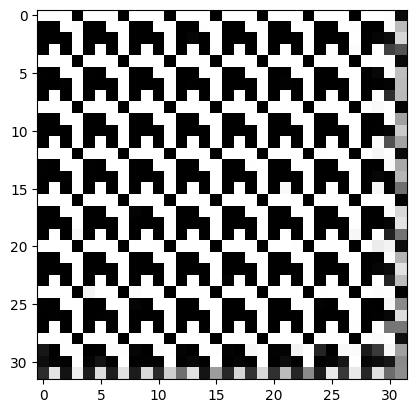

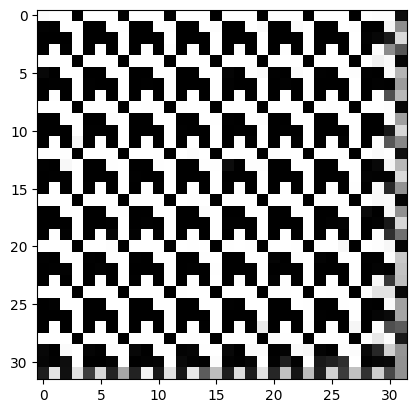

Iteration 2000, Generator Cost: 0.10955855995416641, Discriminator Cost: -0.42538052797317505 Time: 1.9084675312042236
Iteration 2001, Generator Cost: 0.10977853089570999, Discriminator Cost: -0.4370381832122803 Time: 2.120083808898926
Iteration 2002, Generator Cost: 0.11039203405380249, Discriminator Cost: -0.4209632873535156 Time: 2.2011466026306152
Iteration 2003, Generator Cost: 0.11013221740722656, Discriminator Cost: -0.4499010145664215 Time: 2.409390449523926
Iteration 2004, Generator Cost: 0.10957451164722443, Discriminator Cost: -0.4202601909637451 Time: 1.9611499309539795
Iteration 2005, Generator Cost: 0.10975741595029831, Discriminator Cost: -0.44069355726242065 Time: 2.309920310974121
Iteration 2006, Generator Cost: 0.10937054455280304, Discriminator Cost: -0.429399698972702 Time: 2.0627996921539307
Iteration 2007, Generator Cost: 0.10948633402585983, Discriminator Cost: -0.4212658703327179 Time: 2.790104627609253
Iteration 2008, Generator Cost: 0.10984876751899719, Discri

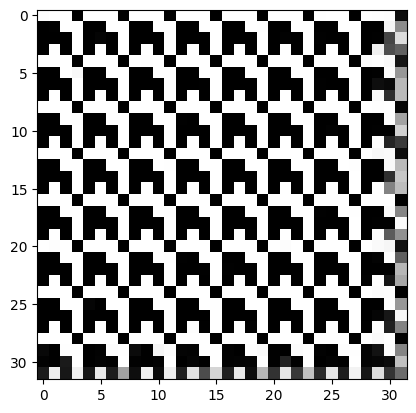

Iteration 2100, Generator Cost: 0.10978307574987411, Discriminator Cost: -0.4431011378765106 Time: 0.715806245803833
Iteration 2101, Generator Cost: 0.10973171144723892, Discriminator Cost: -0.42796745896339417 Time: 0.7993783950805664
Iteration 2102, Generator Cost: 0.10853184014558792, Discriminator Cost: -0.45150691270828247 Time: 0.7017052173614502
Iteration 2103, Generator Cost: 0.11004374176263809, Discriminator Cost: -0.4334568977355957 Time: 0.7275638580322266
Iteration 2104, Generator Cost: 0.11042202264070511, Discriminator Cost: -0.4410932660102844 Time: 0.7402627468109131
Iteration 2105, Generator Cost: 0.10988300293684006, Discriminator Cost: -0.43280884623527527 Time: 0.7897722721099854
Iteration 2106, Generator Cost: 0.1094130128622055, Discriminator Cost: -0.42823857069015503 Time: 0.7776517868041992
Iteration 2107, Generator Cost: 0.1097787469625473, Discriminator Cost: -0.4309353232383728 Time: 0.7505993843078613
Iteration 2108, Generator Cost: 0.11154995113611221, Di

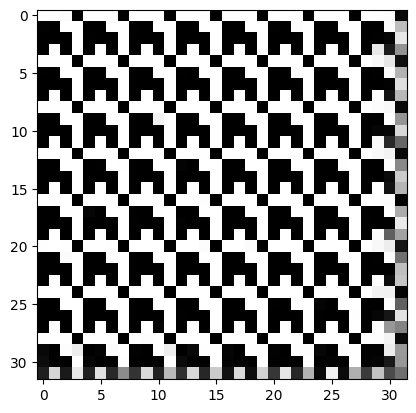

Iteration 2200, Generator Cost: 0.1101294532418251, Discriminator Cost: -0.4305339753627777 Time: 1.0299692153930664
Iteration 2201, Generator Cost: 0.1101020872592926, Discriminator Cost: -0.4498337507247925 Time: 1.2139203548431396
Iteration 2202, Generator Cost: 0.11024942994117737, Discriminator Cost: -0.45053544640541077 Time: 1.1494638919830322
Iteration 2203, Generator Cost: 0.11034838855266571, Discriminator Cost: -0.44986265897750854 Time: 1.0386431217193604
Iteration 2204, Generator Cost: 0.11027029901742935, Discriminator Cost: -0.4291590750217438 Time: 0.8619024753570557
Iteration 2205, Generator Cost: 0.1102626696228981, Discriminator Cost: -0.455488383769989 Time: 0.9758865833282471
Iteration 2206, Generator Cost: 0.11005591601133347, Discriminator Cost: -0.4289188086986542 Time: 1.126112461090088
Iteration 2207, Generator Cost: 0.11025887727737427, Discriminator Cost: -0.4338496923446655 Time: 1.0363574028015137
Iteration 2208, Generator Cost: 0.11010923236608505, Discri

KeyboardInterrupt: 

In [46]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
train(mode = 'wgan'
      , train_loader=train_loader
      , gen_iters = GEN_ITERS
      , critic_iters=CRITIC_ITERS
      ,batch_size = BATCH_SIZE
      ,discriminator = discriminator
      ,generator = generator
      ,val_loader=test_loader)